In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [277]:
# #Define the number of elements in each set I, J, K
# i_num = 30
# k_num = 2
# j_num = 200 #Without I and K, so real j_num_real = j_num + i_num + k_num
# degree_to_m = 111111

# #Define empty data frames
# I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
# J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
# K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])



In [278]:
# #Define sets of I, J, K, where J contains I and K

# for i in range(i_num):
#     I.loc[i, 'Point number'] = 'i'+ str(i)
#     I.loc[i, 'Latitude'] = round(random.uniform(0, 5000), 0)
#     I.loc[i, 'Longitude'] = round(random.uniform(0, 5000), 0)

# I.index = I['Point number']
    
    
# for k in range(k_num):
#     K.loc[k, 'Point number'] = 'k'+ str(k)
#     K.loc[k, 'Latitude'] = round(random.uniform(0, 5000), 0)
#     K.loc[k, 'Longitude'] = round(random.uniform(0, 5000), 0)

# K.index = K['Point number']


# for j in range(j_num):
#     J.loc[j, 'Point number'] = 'j'+ str(j)
#     J.loc[j, 'Latitude'] = round(random.uniform(0, 5000), 0)
#     J.loc[j, 'Longitude'] = round(random.uniform(0, 5000), 0)

# J.index = J['Point number'] 
# J = pd.concat([J, K, I], axis = 0) #Include K to J
# J

In [279]:
### PASSAU  ###

#Define sets of I, J, K, where J contains I and K for Passau

#Define the number of elements in each set I, J, K
i_num = 27
k_num = 5
j_num = 1500 #Without I and K, so real j_num_real = j_num + i_num + k_num
degree_to_m = 111111

#Define empty data frames
I_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])

column_types = {
    'Name': 'str',  # Example: 'int', 'float', 'str', 'datetime64[ns]', etc.
    'Latitude': 'float',
    'Longitude': 'float',
    'Address': 'str'
    # Add more columns and their data types as needed
}

doctors = pd.read_csv('Doctors coordinates.txt', sep = ';', index_col = False, dtype=column_types)

doctors

for i in range(len(doctors['Latitude'])):
    I_coordinates.loc[i, 'Point number'] = 'i'+ str(i)
    I_coordinates.loc[i, 'Latitude'] = doctors.loc[i, 'Latitude']
    I_coordinates.loc[i, 'Longitude'] = doctors.loc[i, 'Longitude']

I_coordinates.index = I_coordinates['Point number']

I = I_coordinates * degree_to_m
I['Point number'] = I_coordinates['Point number']


labs = pd.read_csv('Labs coordinates.txt', sep = ';', index_col = False, dtype=column_types) 
labs

for k in range(len(labs['Latitude'])):
    K_coordinates.loc[k, 'Point number'] = 'k'+ str(k)
    K_coordinates.loc[k, 'Latitude'] = labs.loc[k, 'Latitude']
    K_coordinates.loc[k, 'Longitude'] = labs.loc[k, 'Longitude']

K_coordinates.index = K_coordinates['Point number']

K = K_coordinates * degree_to_m
K['Point number'] = K_coordinates['Point number']


#Define range of coordinates

combined_coordinates = pd.concat([I_coordinates, K_coordinates])

min_latitude = combined_coordinates['Latitude'].min()
max_latitude = combined_coordinates['Latitude'].max()
min_longitude = combined_coordinates['Longitude'].min()
max_longitude = combined_coordinates['Longitude'].max()

grid_spacing = 0.0018

# Create grid points
grid_points = []
for lat in np.arange(min_latitude, max_latitude + grid_spacing, grid_spacing):
    for lon in np.arange(min_longitude, max_longitude + grid_spacing, grid_spacing):
        grid_points.append((round(lat, 6), round(lon, 6)))

J_coordinates = pd.DataFrame(grid_points, columns=['Latitude', 'Longitude'])
J_coordinates['Point number'] = ['j' + str(i) for i in range(len(J_coordinates))]

J_coordinates.index = J_coordinates['Point number'] 
J_coordinates = pd.concat([J_coordinates, K_coordinates, I_coordinates], axis = 0) #Include K to J

river = ['j972', 'j973', 'j918', 'j919', 'j920', 'j866', 'j867', 'j813', 'j814',
'j815', 'j760', 'j761', 'j762', 'j707', 'j708', 'j709', 'j710', 'j654',
'j655', 'j656', 'j657', 'j658', 'j606', 'j610', 'j611', 'j612', 'j613', 'j614',
'j615', 'j616', 'j620', 'j621', 'j622', 'j623', 'j624', 'j625', 'j682', 'j683',
'j684','j685','j686', 'j635', 'j636', 'j637', 'j638', 'j585', 'j586', 'j587', 
'j588', 'j589', 'j590', 'j591', 'j592','j593', 'j531', 'j530', 'j529', 'j528',
'j527', 'j22', 'j23', 'j77', 'j132', 'j133', 'j134', 'j189', 'j190', 'j244',
'j245', 'j300', 'j301', 'j356', 'j411', 'j412', 'j467', 'j523', 'j524', 'j525', 'j526',

'j246', 'j247', 'j191', 'j192', 'j193', 'j194', 'j135', 'j136', 'j137', 'j138', 'j139',
'j140', 'j141', 'j78', 'j79', 'j80', 'j81', 'j82', 'j83', 'j84', 'j85', 'j86', 'j87', 'j88',
'j24', 'j25', 'j26', 'j27', 'j28', 'j29', 'j30', 'j31', 'j32', 'j33', 'j34', 'j35', 'j36',
 'j261', 'j262', 'j263', 'j264', 'j266', 'j267', 'j268', 'j269', 'j206', 'j207', 'j208',
'j209', 'j210', 'j211', 'j212', 'j213', 'j214', 'j215', 'j153', 'j154', 'j155', 'j156',
'j157', 'j158', 'j159', 'j160', 'j161', 'j98', 'j99', 'j100', 'j101', 'j102', 'j103', 
'j104', 'j105', 'j106', 'j107', 'j43', 'j44', 'j45', 'j46', 'j47', 'j48', 'j49', 'j50', 
'j51', 'j52', 'j53'
 ]

J_coordinates = J_coordinates.drop(index = river) #excluding locations on the river

J = J_coordinates * degree_to_m
J['Point number'] = J_coordinates['Point number']
J


,Latitude,Longitude,Point number
Point number,,,
j0,5395057.382715,1488454.289322,j0
j1,5395057.382715,1488654.289122,j1
j2,5395057.382715,1488854.288922,j2
j3,5395057.382715,1489054.288722,j3
j4,5395057.382715,1489254.288522,j4
...,...,...,...
i72,5396271.431962,1494016.582913,i72
i73,5396276.176425,1494035.132745,i73
i74,5397218.901411,1495210.024008,i74


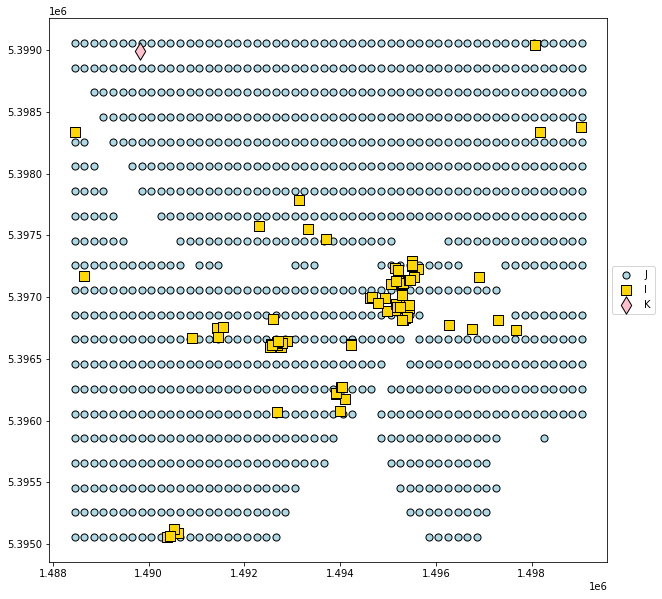

In [280]:
axs, fig = plt.subplots(1, 1, figsize = (10, 10))

fig.scatter(J['Longitude'], J['Latitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [281]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import shapely
#%pip install folium matplotlib mapclassify
import folium
import matplotlib



with open('Polygon Passau.txt', 'r') as file:
    # Read the contents of the file into a string
    polygon_str = file.read()

# Making Passau polygon

passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)

passau_poly = shapely.wkt.loads(polygon_str)
passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
folium.GeoJson(passau_gdf).add_to(passau_map)


# Assuming I_coordinates is your DataFrame with doctor coordinates
geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326")

for idx, row in geo_doctors.iterrows():
    coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
    folium.Marker([row['Latitude'], row['Longitude']], 
                  icon=folium.Icon(icon='circle', prefix='fa', color='orange', size = 0.1), 
                  popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
    
geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

for idx, row in geo_labs.iterrows():
    coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
    folium.Marker([row['Latitude'], row['Longitude']], 
                  icon=folium.Icon(icon='circle', prefix='fa', color='red'), size = 0.1, 
                  popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
    
geo_bases = gpd.GeoDataFrame(J_coordinates, geometry=gpd.points_from_xy(J_coordinates["Latitude"], J_coordinates["Longitude"]), crs="epsg:4326")

for idx, row in geo_bases.iterrows():
    coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
    folium.CircleMarker([row['Latitude'], row['Longitude']],  
                  popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)


#Custom legend

legend_html = '''
     <div style="position: fixed; 
                 bottom: 100px; right: 100px; width: 300px; height: 150px; 
                 border:2px solid grey; z-index:9999; font-size:16px;
                 background-color:white; opacity: 0.9;
                 ">
     &nbsp; <i class="fa fa-map-marker fa-3x" style="color:orange"></i> Doctors &nbsp; <br>
     &nbsp; <i class="fa fa-map-marker fa-3x" style="color:red"></i> Laboratories &nbsp; <br>
     &nbsp; <svg height="40" width="40">
          <circle cx="20" cy="20" r="18" fill="none" stroke="#3388FF" stroke-width="2" />
        </svg> Bases &nbsp; 
      </div>
     '''



# Add the legend to the map
passau_map.get_root().html.add_child(folium.Element(legend_html))

passau_map

In [282]:
#Define constants

B = 91800 #battery load: meters of travel
S = 1020 #meters of service time

p = 0.97

alpha = 15900 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 203000
    else:
        beta[j] = 76920
        
gamma = 0.0045 / 1000 # variable cost in euro per m
        
q_j = {}
for j in J.index:
    if j.startswith('j'):
        q_j[j] = 255
    else:
        q_j[j] = 45

up_bound = 10
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

softlimit = 200
hardlimit = 10000

Deterministic model

In [283]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 10,
 'i1': 2,
 'i2': 9,
 'i3': 4,
 'i4': 2,
 'i5': 5,
 'i6': 2,
 'i7': 4,
 'i8': 9,
 'i9': 2,
 'i10': 14,
 'i11': 8,
 'i12': 0,
 'i13': 1,
 'i14': 7,
 'i15': 15,
 'i16': 0,
 'i17': 3,
 'i18': 5,
 'i19': 10,
 'i20': 5,
 'i21': 8,
 'i22': 7,
 'i23': 2,
 'i24': 8,
 'i25': 8,
 'i26': 12,
 'i27': 14,
 'i28': 7,
 'i29': 9,
 'i30': 4,
 'i31': 6,
 'i32': 2,
 'i33': 6,
 'i34': 1,
 'i35': 1,
 'i36': 6,
 'i37': 4,
 'i38': 1,
 'i39': 1,
 'i40': 9,
 'i41': 3,
 'i42': 11,
 'i43': 2,
 'i44': 1,
 'i45': 4,
 'i46': 6,
 'i47': 6,
 'i48': 5,
 'i49': 11,
 'i50': 0,
 'i51': 2,
 'i52': 3,
 'i53': 1,
 'i54': 15,
 'i55': 0,
 'i56': 8,
 'i57': 0,
 'i58': 8,
 'i59': 1,
 'i60': 1,
 'i61': 2,
 'i62': 10,
 'i63': 2,
 'i64': 3,
 'i65': 2,
 'i66': 10,
 'i67': 7,
 'i68': 8,
 'i69': 5,
 'i70': 5,
 'i71': 5,
 'i72': 1,
 'i73': 0,
 'i74': 3,
 'i75': 4,
 'i76': 9}

In [284]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Longitude'], PointsSet1.loc[point1, 'Latitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Longitude'], PointsSet2.loc[point2, 'Latitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 4161.767129977308,
 ('k0', 'j1'): 4100.403874253124,
 ('k0', 'j2'): 4048.0017366376105,
 ('k0', 'j3'): 4004.912486890546,
 ('k0', 'j4'): 3971.439264987311,
 ('k0', 'j5'): 3947.826678479448,
 ('k0', 'j6'): 3934.2522759915905,
 ('k0', 'j7'): 3930.820054260468,
 ('k0', 'j8'): 3937.556535061752,
 ('k0', 'j9'): 3954.409750473379,
 ('k0', 'j10'): 3981.2512257417548,
 ('k0', 'j11'): 4017.880785974353,
 ('k0', 'j12'): 4064.0337766969537,
 ('k0', 'j13'): 4119.390113349927,
 ('k0', 'j14'): 4183.584481493972,
 ('k0', 'j15'): 4256.2170012381475,
 ('k0', 'j16'): 4336.8637342508355,
 ('k0', 'j17'): 4425.086527661631,
 ('k0', 'j18'): 4520.441830742323,
 ('k0', 'j19'): 4622.488264231352,
 ('k0', 'j20'): 4730.792851181433,
 ('k0', 'j21'): 4844.9359220345705,
 ('k0', 'j37'): 7200.099425282223,
 ('k0', 'j38'): 7368.475561592201,
 ('k0', 'j39'): 7538.397197655254,
 ('k0', 'j40'): 7709.762146619819,
 ('k0', 'j41'): 7882.476276227165,
 ('k0', 'j42'): 8056.452815794278,
 ('k0', 'j54'): 3973.41

In [285]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j67'),
 ('k0', 'j68'),
 ('k0', 'j69'),
 ('k0', 'j70'),
 ('k0', 'j71'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j89'),
 ('k0', 'j90'),
 ('k0', 'j91'),
 ('k0', 'j92'),
 ('k0', 'j93'),
 ('k0', 'j94'),
 ('k0', 'j95'),
 ('k0', 'j96'),
 ('k0', 'j97'),
 ('k0', 'j108'),
 ('k0', 'j109'),
 ('k0', 'j110'),

In [286]:
#Define set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= 0.5*B:
        P.append((i, k))
        
P

[('i0', 'k0'),
 ('i1', 'k0'),
 ('i2', 'k0'),
 ('i3', 'k0'),
 ('i4', 'k0'),
 ('i5', 'k0'),
 ('i6', 'k0'),
 ('i7', 'k0'),
 ('i8', 'k0'),
 ('i9', 'k0'),
 ('i10', 'k0'),
 ('i11', 'k0'),
 ('i12', 'k0'),
 ('i13', 'k0'),
 ('i14', 'k0'),
 ('i15', 'k0'),
 ('i16', 'k0'),
 ('i17', 'k0'),
 ('i18', 'k0'),
 ('i19', 'k0'),
 ('i20', 'k0'),
 ('i21', 'k0'),
 ('i22', 'k0'),
 ('i23', 'k0'),
 ('i24', 'k0'),
 ('i25', 'k0'),
 ('i26', 'k0'),
 ('i27', 'k0'),
 ('i28', 'k0'),
 ('i29', 'k0'),
 ('i30', 'k0'),
 ('i31', 'k0'),
 ('i32', 'k0'),
 ('i33', 'k0'),
 ('i34', 'k0'),
 ('i35', 'k0'),
 ('i36', 'k0'),
 ('i37', 'k0'),
 ('i38', 'k0'),
 ('i39', 'k0'),
 ('i40', 'k0'),
 ('i41', 'k0'),
 ('i42', 'k0'),
 ('i43', 'k0'),
 ('i44', 'k0'),
 ('i45', 'k0'),
 ('i46', 'k0'),
 ('i47', 'k0'),
 ('i48', 'k0'),
 ('i49', 'k0'),
 ('i50', 'k0'),
 ('i51', 'k0'),
 ('i52', 'k0'),
 ('i53', 'k0'),
 ('i54', 'k0'),
 ('i55', 'k0'),
 ('i56', 'k0'),
 ('i57', 'k0'),
 ('i58', 'k0'),
 ('i59', 'k0'),
 ('i60', 'k0'),
 ('i61', 'k0'),
 ('i62', 'k0'),
 (

In [287]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_final.keys())
KJ_feas


[('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j21'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j67'),
 ('k0', 'j68'),
 ('k0', 'j69'),
 ('k0', 'j73'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j113'),
 ('k0', 'j114'),
 ('k0', 'j115'),
 ('k0', 'j116'),
 ('k0', 'j117'),
 ('k0', 'j118'),
 ('k0', 'j119'),
 ('k0', 'j120'),
 ('k0', 'j121'),
 ('k0', 'j122'),
 ('k0', 'j123'),
 ('k0', 'j126'),
 ('k0', 'j127'),
 ('k0', 'j128'),
 ('k0', 'j129'),
 ('k0', 'j130'),
 ('k0', 'j131'),
 ('k0', 'j168'),
 ('k0', 'j169'),
 ('k0', 'j170'),
 ('k0', 'j171'),
 ('k0', 'j172'),
 ('k0', 'j173'),
 ('k0', 'j174'),
 ('k0', 'j175'),
 ('k0', 'j176'),
 ('k0', 'j179'),
 ('k0', 'j180'),
 ('k0', 'j181'),
 ('k0', 'j182'),
 ('k0', 'j183'),
 ('k0', 'j184'),
 ('k0', 'j185'),
 ('k0', 'j18

In [288]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_final = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_final.keys())
N_i

{'i0': [('k0', 'j699'),
  ('k0', 'j700'),
  ('k0', 'j701'),
  ('k0', 'j752'),
  ('k0', 'j753'),
  ('k0', 'j754'),
  ('k0', 'j755'),
  ('k0', 'j805'),
  ('k0', 'j806'),
  ('k0', 'j807'),
  ('k0', 'j808'),
  ('k0', 'j809'),
  ('k0', 'j859'),
  ('k0', 'j860'),
  ('k0', 'j861'),
  ('k0', 'j862'),
  ('k0', 'j863'),
  ('k0', 'j912'),
  ('k0', 'j913'),
  ('k0', 'j914'),
  ('k0', 'j915'),
  ('k0', 'j916'),
  ('k0', 'j917'),
  ('k0', 'j966'),
  ('k0', 'j967'),
  ('k0', 'j968'),
  ('k0', 'j969'),
  ('k0', 'j970'),
  ('k0', 'j971'),
  ('k0', 'j1021'),
  ('k0', 'j1022'),
  ('k0', 'j1023'),
  ('k0', 'j1024'),
  ('k0', 'j1025'),
  ('k0', 'j1075'),
  ('k0', 'j1076'),
  ('k0', 'j1077'),
  ('k0', 'j1078'),
  ('k0', 'j1079'),
  ('k0', 'j1130'),
  ('k0', 'j1131'),
  ('k0', 'j1132'),
  ('k0', 'j1133'),
  ('k0', 'i0'),
  ('k0', 'i1')],
 'i1': [('k0', 'j694'),
  ('k0', 'j695'),
  ('k0', 'j696'),
  ('k0', 'j697'),
  ('k0', 'j698'),
  ('k0', 'j699'),
  ('k0', 'j747'),
  ('k0', 'j748'),
  ('k0', 'j749'),
  ('k

In [289]:
#Define sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []
    
O_j_final = {key : val for key, val in O_j.items() if val != []}   
 
J_feas = list(O_j_final.keys())
J_feas

['j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j21',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j73',
 'j74',
 'j75',
 'j76',
 'j113',
 'j114',
 'j115',
 'j116',
 'j117',
 'j118',
 'j119',
 'j120',
 'j121',
 'j122',
 'j123',
 'j126',
 'j127',
 'j128',
 'j129',
 'j130',
 'j131',
 'j168',
 'j169',
 'j170',
 'j171',
 'j172',
 'j173',
 'j174',
 'j175',
 'j176',
 'j179',
 'j180',
 'j181',
 'j182',
 'j183',
 'j184',
 'j185',
 'j186',
 'j187',
 'j188',
 'j223',
 'j224',
 'j225',
 'j226',
 'j227',
 'j228',
 'j229',
 'j230',
 'j231',
 'j232',
 'j233',
 'j234',
 'j235',
 'j236',
 'j237',
 'j238',
 'j239',
 'j240',
 'j241',
 'j242',
 'j243',
 'j248',
 'j249',
 'j250',
 'j251',
 'j252',
 'j253',
 'j254',
 'j255',
 'j256',
 'j257',
 'j258',
 'j259',
 'j260',
 'j279',
 'j280',
 'j281',
 'j282',
 'j283',
 'j284',
 'j285',
 'j286',
 'j287',
 'j288',
 'j289',
 'j290',
 'j291',
 'j292',
 'j293',
 'j294',
 'j295',
 'j296

In [290]:
model_det = gp.Model('Deterministic model without relaxation')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [291]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

KeyboardInterrupt: 

In [ ]:
model_det.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

def softtime(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()
            
model_det.setParam('TimeLimit', hardlimit)
model_det.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27860 rows, 14152 columns and 30914 nonzeros
Model fingerprint: 0xdb32fdba
Variable types: 0 continuous, 14152 integer (232 binary)
Coefficient statistics:
  Matrix range     [9e-02, 9e+04]
  Objective range  [2e+04, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 1.096368e+07
Presolve removed 27602 rows and 13201 columns
Presolve time: 0.03s
Presolved: 258 rows, 951 columns, 1672 nonzeros
Found heuristic solution: objective 9763682.7511
Variable types: 0 continuous, 951 integer (284 binary)
Found heuristic solution: objective 9763682.7358

Root relaxation: objective 4.221300e+06, 708 iterations, 0.00 seconds (0.00 work units)

    Nod

In [ ]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, int(v.X)))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 10
0
4.96368e+06 
x_ikj[i0,k1,k1] 4
x_ikj[i1,k1,j139] 4
x_ikj[i2,k0,j175] 2
x_ikj[i3,k1,j97] 8
x_ikj[i6,k0,k0] 1
x_ikj[i7,k0,j178] 4
x_ikj[i8,k0,j49] 7
x_ikj[i9,k0,j49] 5
x_ikj[i10,k0,j178] 6
x_ikj[i11,k1,j139] 12
x_ikj[i12,k1,i12] 2
x_ikj[i13,k1,i12] 2
x_ikj[i14,k1,i12] 10
x_ikj[i15,k0,j175] 9
x_ikj[i16,k0,j178] 2
x_ikj[i17,k0,j175] 5
x_ikj[i18,k0,k0] 2
x_ikj[i19,k0,k0] 17
x_ikj[i20,k1,k1] 12
x_ikj[i21,k1,k1] 2
x_ikj[i22,k0,j175] 2
x_ikj[i23,k1,j97] 10
x_ikj[i24,k0,j175] 5
x_ikj[i25,k0,k0] 8
x_ikj[i26,k1,k1] 13
x_ikj[i27,k1,k1] 7
x_ikj[i28,k1,j139] 6
x_ikj[i29,k1,k1] 1
y_j[j49] 1
y_j[j97] 1
y_j[j139] 1
y_j[j175] 1
y_j[j178] 1
y_j[k0] 1
y_j[k1] 1
y_j[i12] 1


1
4.96368e+06 
x_ikj[i0,k1,k1] 4
x_ikj[i1,k1,j139] 4
x_ikj[i2,k0,j175] 2
x_ikj[i3,k1,j97] 8
x_ikj[i6,k0,k0] 1
x_ikj[i7,k0,j178] 4
x_ikj[i8,k0,j49] 7
x_ikj[i9,k0,j49] 5
x_ikj[i10,k0,j178] 6
x_ikj[i11,k1,j139] 12
x_ikj[i12,k1,i12] 2
x_ikj[i13,k1,i12] 2
x_ikj[i14,k1,i12] 10
x_ikj[i15,k0,j175] 9
x_ikj[i16,k0

In [ ]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
    return results_doctors, results_locations, results_labs

SolutionSummary(model_det)

(      i  Number of drones
 0    i0                 4
 1    i1                 4
 2   i10                 6
 3   i11                12
 4   i12                 2
 5   i13                 2
 6   i14                10
 7   i15                 9
 8   i16                 2
 9   i17                 5
 10  i18                 2
 11  i19                17
 12   i2                 2
 13  i20                12
 14  i21                 2
 15  i22                 2
 16  i23                10
 17  i24                 5
 18  i25                 8
 19  i26                13
 20  i27                 7
 21  i28                 6
 22  i29                 1
 23   i3                 8
 24   i6                 1
 25   i7                 4
 26   i8                 7
 27   i9                 5,
       j  Number of drones
 0   i12                14
 1  j139                22
 2  j175                23
 3  j178                12
 4   j49                12
 5   j97                18
 6    k0                28


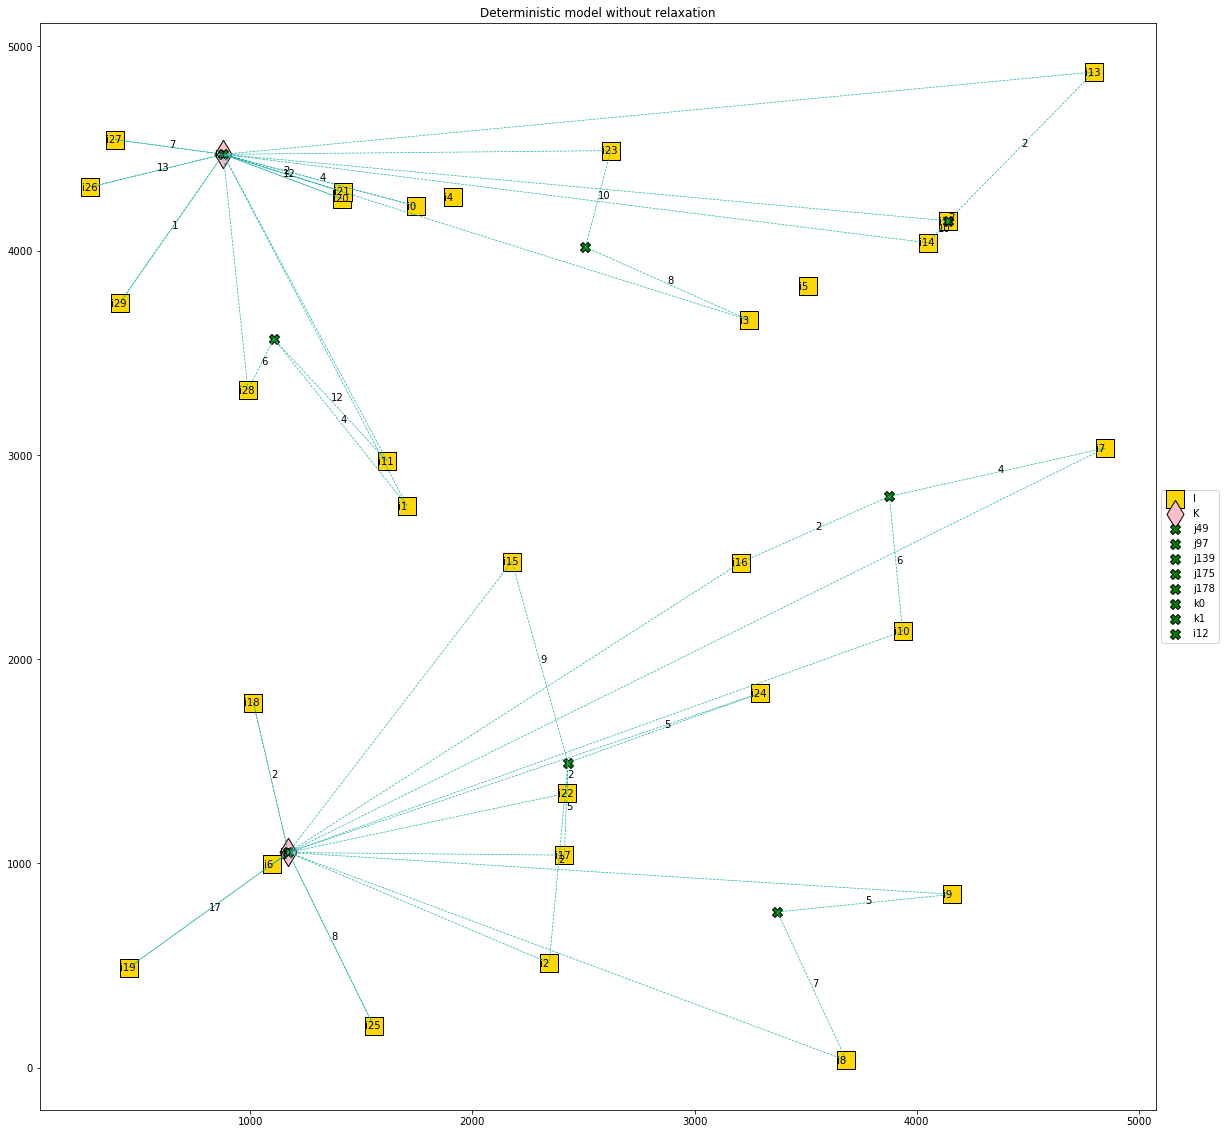

In [ ]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (20, 20))
                
        fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 300, label = 'I')
        for i in range (len(I.index)):
                fig.annotate(I.index[i], (I['Longitude'][i] - 40, I['Latitude'][i] - 15))
                
        fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
                                marker = 'd', s = 400, label = 'K')
        for k in range (len(K.index)):
                fig.annotate(K.index[k], (K['Longitude'][k] - 40, K['Latitude'][k] - 15))
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        (J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.plot((I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        (I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                         color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                #fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                #(K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                                fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                (J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
                                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

In [ ]:
def SolutionMap(I_coordinates, K_coordinates, J_coordinates, model):
        
        with open('Polygon Passau.txt', 'r') as file:
        # Read the contents of the file into a string
                polygon_str = file.read()

        # Making Passau polygon
        passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
        passau_poly = shapely.wkt.loads(polygon_str)
        passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
        folium.GeoJson(passau_gdf).add_to(passau_map)

        # Assuming I_coordinates is your DataFrame with doctor coordinates
        geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326") 
        
        indices_xi = []
        indices_y = pd.DataFrame(columns = ['Location name', 'Latitude', 'Longitude'])
        indices_x = pd.DataFrame(columns = ['I', 'J', 'Number of drones'])
        
        
        i = 0
        for v in model.getVars():
                if v.x > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_xi = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                indices_x.loc[i, 'I'] = str(indices_xi[0])
                                indices_x.loc[i, 'J'] = str(indices_xi[2])
                                indices_x.loc[i, 'Number of drones'] = int(v.x)
                                i += 1
                                
                        else:
                                y_name = v.varName[4:-1]
                                indices_y.loc[str(y_name), 'Latitude'] = J_coordinates.loc[str(y_name), 'Latitude']
                                indices_y.loc[str(y_name), 'Longitude'] = J_coordinates.loc[str(y_name), 'Longitude']
                                # 
                                # fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
                                #         edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                        
        geo_solution_y = gpd.GeoDataFrame(indices_y, geometry=gpd.points_from_xy(indices_y["Latitude"], indices_y["Longitude"]), crs="epsg:4326")
        
        
        
        for idx, row in geo_doctors.iterrows():
                coordinates_label = f"Lat: {row['Latitude']}, Long: {row['Longitude']}"
                folium.Marker([row['Latitude'], row['Longitude']], 
                        icon=folium.Icon(icon='circle', prefix='fa', color='orange', size = 0.1), 
                        popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
                
        
        
        for idx, row in geo_solution_y.iterrows():
                coordinates_label = f"Lat: {row['Latitude']}, Long: {row['Longitude']}"
                folium.Marker([row['Latitude'], row['Longitude']], 
                        icon=folium.Icon(icon='circle', prefix='fa', color='green', size = 0.1), 
                        popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
        
        geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

        for idx, row in geo_labs.iterrows():
                coordinates_label = f"Lat: {row['Latitude']}, Long: {row['Longitude']}"
                folium.Marker([row['Latitude'], row['Longitude']], 
                                icon=folium.Icon(icon='circle', prefix='fa', color='red'), size = 0.1, 
                                popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
        
        
        for idx, row in indices_x.iterrows():
                point_i = I_coordinates.loc[row['I'], ['Latitude', 'Longitude']]
                point_j = J_coordinates.loc[row['J'], ['Latitude', 'Longitude']]
                folium.PolyLine(locations=[(point_i['Latitude'], point_i['Longitude']), 
                                        (point_j['Latitude'], point_j['Longitude'])], color='blue').add_to(passau_map)
                
                label = str(row['Number of drones'])  # Just the number of drones without additional text
                folium.Marker([(point_i['Latitude'] + point_j['Latitude']) / 2, 
                        (point_i['Longitude'] + point_j['Longitude']) / 2], 
                      icon=folium.DivIcon(html=f"<div style='background-color: white; border-radius: 50%; padding: 5px;'><div style='font-size: 10pt; color: {'blue'};'>{label}</div></div>")).add_to(passau_map)
        

        return passau_map


SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_det)

Probabilistic model

In [ ]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))


g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = mu[i] * 7

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in I_feasG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

I_feasG

[('i0', 1),
 ('i0', 2),
 ('i0', 3),
 ('i0', 4),
 ('i0', 5),
 ('i0', 6),
 ('i0', 7),
 ('i0', 8),
 ('i0', 9),
 ('i0', 10),
 ('i0', 11),
 ('i0', 12),
 ('i0', 13),
 ('i0', 14),
 ('i0', 15),
 ('i0', 16),
 ('i0', 17),
 ('i0', 18),
 ('i0', 19),
 ('i0', 20),
 ('i0', 21),
 ('i0', 22),
 ('i0', 23),
 ('i0', 24),
 ('i0', 25),
 ('i0', 26),
 ('i0', 27),
 ('i0', 28),
 ('i0', 29),
 ('i0', 30),
 ('i1', 1),
 ('i1', 2),
 ('i1', 3),
 ('i1', 4),
 ('i1', 5),
 ('i1', 6),
 ('i1', 7),
 ('i1', 8),
 ('i1', 9),
 ('i1', 10),
 ('i1', 11),
 ('i1', 12),
 ('i1', 13),
 ('i1', 14),
 ('i1', 15),
 ('i2', 1),
 ('i2', 2),
 ('i2', 3),
 ('i2', 4),
 ('i2', 5),
 ('i3', 1),
 ('i3', 2),
 ('i3', 3),
 ('i3', 4),
 ('i3', 5),
 ('i3', 6),
 ('i3', 7),
 ('i3', 8),
 ('i3', 9),
 ('i3', 10),
 ('i3', 11),
 ('i3', 12),
 ('i3', 13),
 ('i3', 14),
 ('i3', 15),
 ('i3', 16),
 ('i3', 17),
 ('i3', 18),
 ('i3', 19),
 ('i3', 20),
 ('i3', 21),
 ('i3', 22),
 ('i3', 23),
 ('i3', 24),
 ('i3', 25),
 ('i3', 26),
 ('i3', 27),
 ('i3', 28),
 ('i3', 29),
 ('i3

In [ ]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [ ]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

{('i0', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 19): <gurobi.Constr *Awaiting

In [ ]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_prob.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [ ]:
model_prob.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

In [ ]:
model_prob.setParam('TimeLimit', hardlimit)
model_prob.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29382 rows, 14927 columns and 1312206 nonzeros
Model fingerprint: 0xe9968de1
Variable types: 0 continuous, 14927 integer (1007 binary)
Coefficient statistics:
  Matrix range     [1e-13, 9e+04]
  Objective range  [2e+04, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.297801e+07
Presolve removed 29124 rows and 13975 columns
Presolve time: 0.75s
Presolved: 258 rows, 952 columns, 1700 nonzeros
Found heuristic solution: objective 1.177801e+07
Variable types: 0 continuous, 952 integer (230 binary)
Found heuristic solution: objective

In [ ]:
ListSolution(model_prob)

Number of solutions found: 10
0
6.97801e+06 
x_ikj[i0,k1,j138] 9
x_ikj[i0,k1,k1] 3
x_ikj[i1,k1,j138] 7
x_ikj[i2,k0,j175] 3
x_ikj[i3,k1,j97] 13
x_ikj[i6,k0,i6] 3
x_ikj[i7,k0,j178] 9
x_ikj[i8,k0,j49] 10
x_ikj[i9,k0,j49] 13
x_ikj[i10,k0,j178] 17
x_ikj[i11,k1,j138] 14
x_ikj[i12,k1,i12] 7
x_ikj[i13,k1,i12] 3
x_ikj[i14,k1,i12] 16
x_ikj[i15,k0,j175] 13
x_ikj[i16,k0,j178] 10
x_ikj[i17,k0,j175] 9
x_ikj[i18,k0,i6] 9
x_ikj[i19,k0,i6] 20
x_ikj[i20,k1,k1] 13
x_ikj[i21,k1,k1] 7
x_ikj[i22,k0,j175] 13
x_ikj[i23,k1,j97] 13
x_ikj[i24,k0,j175] 9
x_ikj[i25,k0,i6] 13
x_ikj[i26,k1,k1] 17
x_ikj[i27,k1,k1] 10
x_ikj[i28,k1,j138] 10
x_ikj[i29,k1,j138] 7
y_j[j49] 1
y_j[j97] 1
y_j[j138] 1
y_j[j175] 1
y_j[j178] 1
y_j[k1] 1
y_j[i6] 1
y_j[i12] 1


1
7.27801e+06 
x_ikj[i0,k1,j138] 9
x_ikj[i0,k1,k1] 3
x_ikj[i1,k1,j138] 7
x_ikj[i2,k0,j175] 3
x_ikj[i3,k1,j97] 13
x_ikj[i6,k0,i6] 3
x_ikj[i7,k0,j178] 9
x_ikj[i8,k0,j49] 10
x_ikj[i9,k0,j49] 13
x_ikj[i10,k0,j178] 17
x_ikj[i11,k1,j138] 14
x_ikj[i12,k1,i12] 7
x_ikj[i13,k1,i12] 

In [ ]:
SolutionSummary(model_prob)

(      i  Number of drones
 0    i0                12
 1    i1                 7
 2   i10                17
 3   i11                14
 4   i12                 7
 5   i13                 3
 6   i14                16
 7   i15                13
 8   i16                10
 9   i17                 9
 10  i18                 9
 11  i19                20
 12   i2                 3
 13  i20                13
 14  i21                 7
 15  i22                13
 16  i23                13
 17  i24                 9
 18  i25                13
 19  i26                17
 20  i27                10
 21  i28                10
 22  i29                 7
 23   i3                13
 24   i6                 3
 25   i7                 9
 26   i8                10
 27   i9                13,
       j  Number of drones
 0   i12                26
 1    i6                45
 2  j138                47
 3  j175                47
 4  j178                36
 5   j49                23
 6   j97                26


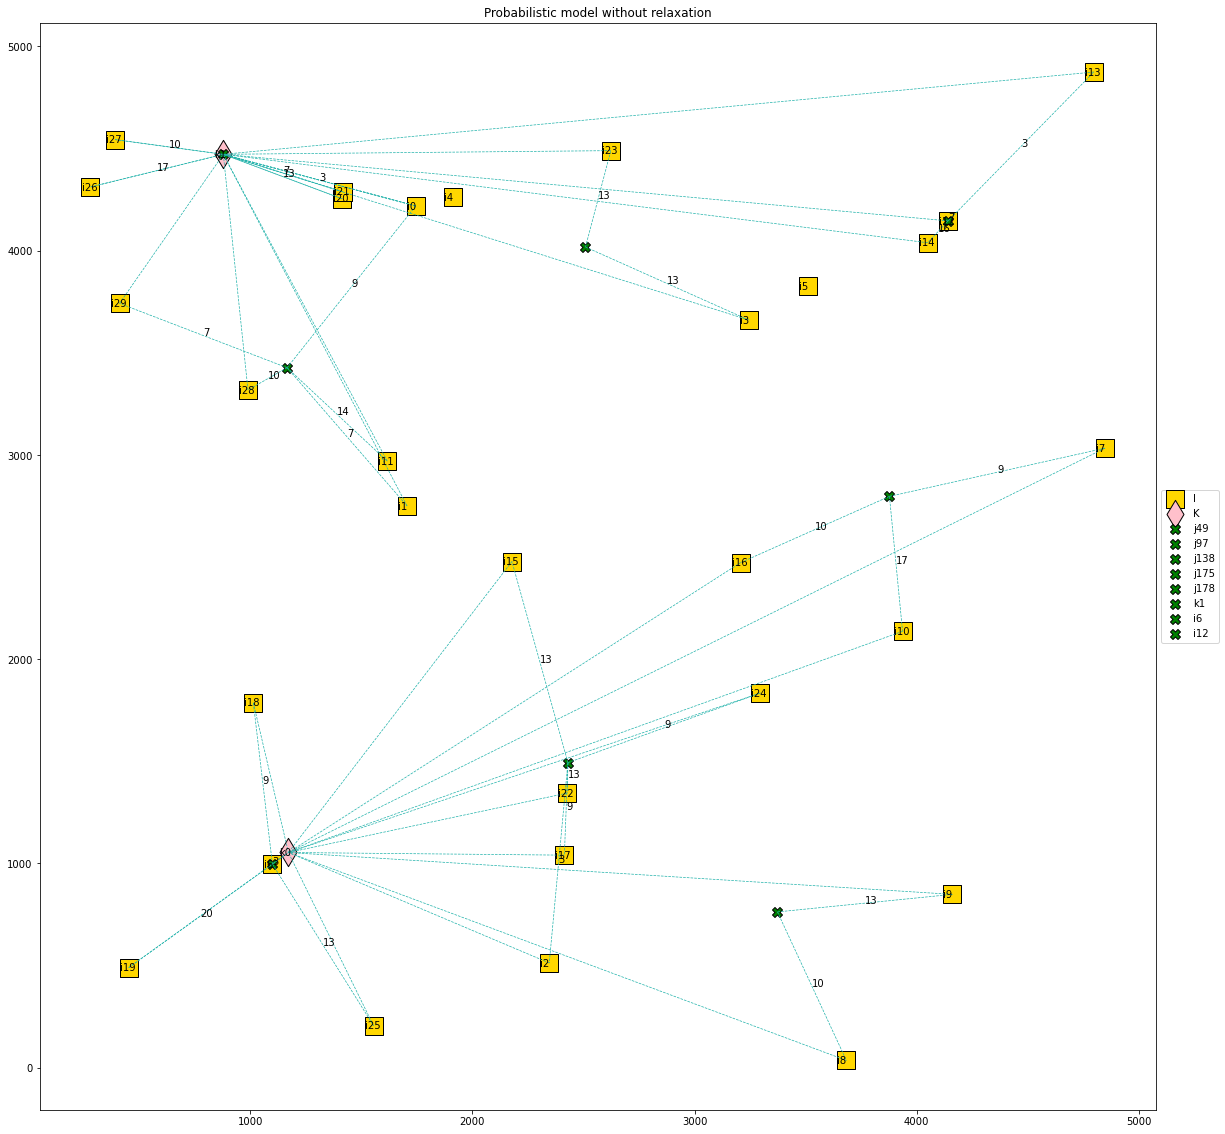

In [ ]:
SolutionGraph(I, K, J, model_prob)

In [ ]:
#SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_prob)

Probabilistic model with relaxed constraints

In [ ]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [ ]:
#Redefine set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= B:
        P.append((i, k))
        
P

[('i0', 'k0'),
 ('i0', 'k1'),
 ('i1', 'k0'),
 ('i1', 'k1'),
 ('i2', 'k0'),
 ('i2', 'k1'),
 ('i3', 'k0'),
 ('i3', 'k1'),
 ('i4', 'k0'),
 ('i4', 'k1'),
 ('i5', 'k0'),
 ('i5', 'k1'),
 ('i6', 'k0'),
 ('i6', 'k1'),
 ('i7', 'k0'),
 ('i7', 'k1'),
 ('i8', 'k0'),
 ('i8', 'k1'),
 ('i9', 'k0'),
 ('i9', 'k1'),
 ('i10', 'k0'),
 ('i10', 'k1'),
 ('i11', 'k0'),
 ('i11', 'k1'),
 ('i12', 'k0'),
 ('i12', 'k1'),
 ('i13', 'k0'),
 ('i13', 'k1'),
 ('i14', 'k0'),
 ('i14', 'k1'),
 ('i15', 'k0'),
 ('i15', 'k1'),
 ('i16', 'k0'),
 ('i16', 'k1'),
 ('i17', 'k0'),
 ('i17', 'k1'),
 ('i18', 'k0'),
 ('i18', 'k1'),
 ('i19', 'k0'),
 ('i19', 'k1'),
 ('i20', 'k0'),
 ('i20', 'k1'),
 ('i21', 'k0'),
 ('i21', 'k1'),
 ('i22', 'k0'),
 ('i22', 'k1'),
 ('i23', 'k0'),
 ('i23', 'k1'),
 ('i24', 'k0'),
 ('i24', 'k1'),
 ('i25', 'k0'),
 ('i25', 'k1'),
 ('i26', 'k0'),
 ('i26', 'k1'),
 ('i27', 'k0'),
 ('i27', 'k1'),
 ('i28', 'k0'),
 ('i28', 'k1'),
 ('i29', 'k0'),
 ('i29', 'k1')]

In [ ]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_final.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [ ]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_final = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_final.keys())

In [ ]:
#Define sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []
    
O_j_final = {key : val for key, val in O_j.items() if val != []}   
 
J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j24',
 'j25',
 'j26',
 'j27',
 'j28',
 'j29',
 'j30',
 'j31',
 'j32',
 'j33',
 'j34',
 'j35',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j43',
 'j44',
 'j45',
 'j46',
 'j47',
 'j48',
 'j49',
 'j50',
 'j51',
 'j52',
 'j53',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j77',
 'j78',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j90',
 'j91',
 'j92',
 'j93',
 'j94',
 'j95',
 'j96',
 'j97',
 'j98',
 'j99',
 'j100',
 'j101',
 'j102',
 'j103',
 'j104',
 'j105',
 'j106',
 'j107',
 'j108',
 'j109',
 'j110',
 'j111',
 'j112',
 'j113',
 'j114',
 'j115',
 'j117',
 'j118',
 'j119',
 'j120',
 'j121',
 'j122',
 'j123',
 'j

In [ ]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [ ]:

model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_prob_rel.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [ ]:
model_prob_rel.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)
model_prob_rel.setParam('TimeLimit', hardlimit)
model_prob_rel.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 28606 rows, 14927 columns and 670789 nonzeros
Model fingerprint: 0xe71a74d9
Variable types: 0 continuous, 14927 integer (1007 binary)
Coefficient statistics:
  Matrix range     [1e-13, 9e+04]
  Objective range  [2e+04, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.297801e+07
Presolve removed 28348 rows and 13975 columns
Presolve time: 0.40s
Presolved: 258 rows, 952 columns, 1700 nonzeros
Found heuristic solution: objective 1.177801e+07
Variable types: 0 continuous, 952 integer (230 binary)
Found heuristic solution: objective 

In [ ]:
ListSolution(model_prob_rel)

Number of solutions found: 10
0
6.97801e+06 
x_ikj[i0,k1,j139] 9
x_ikj[i0,k1,k1] 3
x_ikj[i1,k1,j139] 7
x_ikj[i2,k0,j175] 3
x_ikj[i3,k1,j97] 13
x_ikj[i6,k0,k0] 3
x_ikj[i7,k0,j178] 9
x_ikj[i8,k0,j49] 10
x_ikj[i9,k0,j49] 13
x_ikj[i10,k0,j178] 17
x_ikj[i11,k1,j139] 14
x_ikj[i12,k1,i12] 7
x_ikj[i13,k1,i12] 3
x_ikj[i14,k1,i12] 16
x_ikj[i15,k0,j175] 13
x_ikj[i16,k0,j178] 10
x_ikj[i17,k0,j175] 9
x_ikj[i18,k0,k0] 9
x_ikj[i19,k0,k0] 20
x_ikj[i20,k1,k1] 13
x_ikj[i21,k1,k1] 7
x_ikj[i22,k0,j175] 13
x_ikj[i23,k1,j97] 13
x_ikj[i24,k0,j175] 9
x_ikj[i25,k0,k0] 13
x_ikj[i26,k1,k1] 17
x_ikj[i27,k1,k1] 10
x_ikj[i28,k1,j139] 10
x_ikj[i29,k1,j139] 7
y_j[j49] 1
y_j[j97] 1
y_j[j139] 1
y_j[j175] 1
y_j[j178] 1
y_j[k0] 1
y_j[k1] 1
y_j[i12] 1


1
7.27801e+06 
x_ikj[i0,k1,j139] 9
x_ikj[i0,k1,k1] 3
x_ikj[i1,k1,j139] 7
x_ikj[i2,k0,j175] 3
x_ikj[i3,k1,j97] 13
x_ikj[i6,k0,k0] 3
x_ikj[i7,k0,j178] 9
x_ikj[i8,k0,j49] 10
x_ikj[i9,k0,j49] 13
x_ikj[i10,k0,j178] 17
x_ikj[i11,k1,j139] 14
x_ikj[i12,k1,i12] 7
x_ikj[i13,k1,i12] 

In [ ]:
SolutionSummary(model_prob_rel)

(      i  Number of drones
 0    i0                12
 1    i1                 7
 2   i10                17
 3   i11                14
 4   i12                 7
 5   i13                 3
 6   i14                16
 7   i15                13
 8   i16                10
 9   i17                 9
 10  i18                 9
 11  i19                20
 12   i2                 3
 13  i20                13
 14  i21                 7
 15  i22                13
 16  i23                13
 17  i24                 9
 18  i25                13
 19  i26                17
 20  i27                10
 21  i28                10
 22  i29                 7
 23   i3                13
 24   i6                 3
 25   i7                 9
 26   i8                10
 27   i9                13,
       j  Number of drones
 0   i12                26
 1  j139                47
 2  j175                47
 3  j178                36
 4   j49                23
 5   j97                26
 6    k0                45


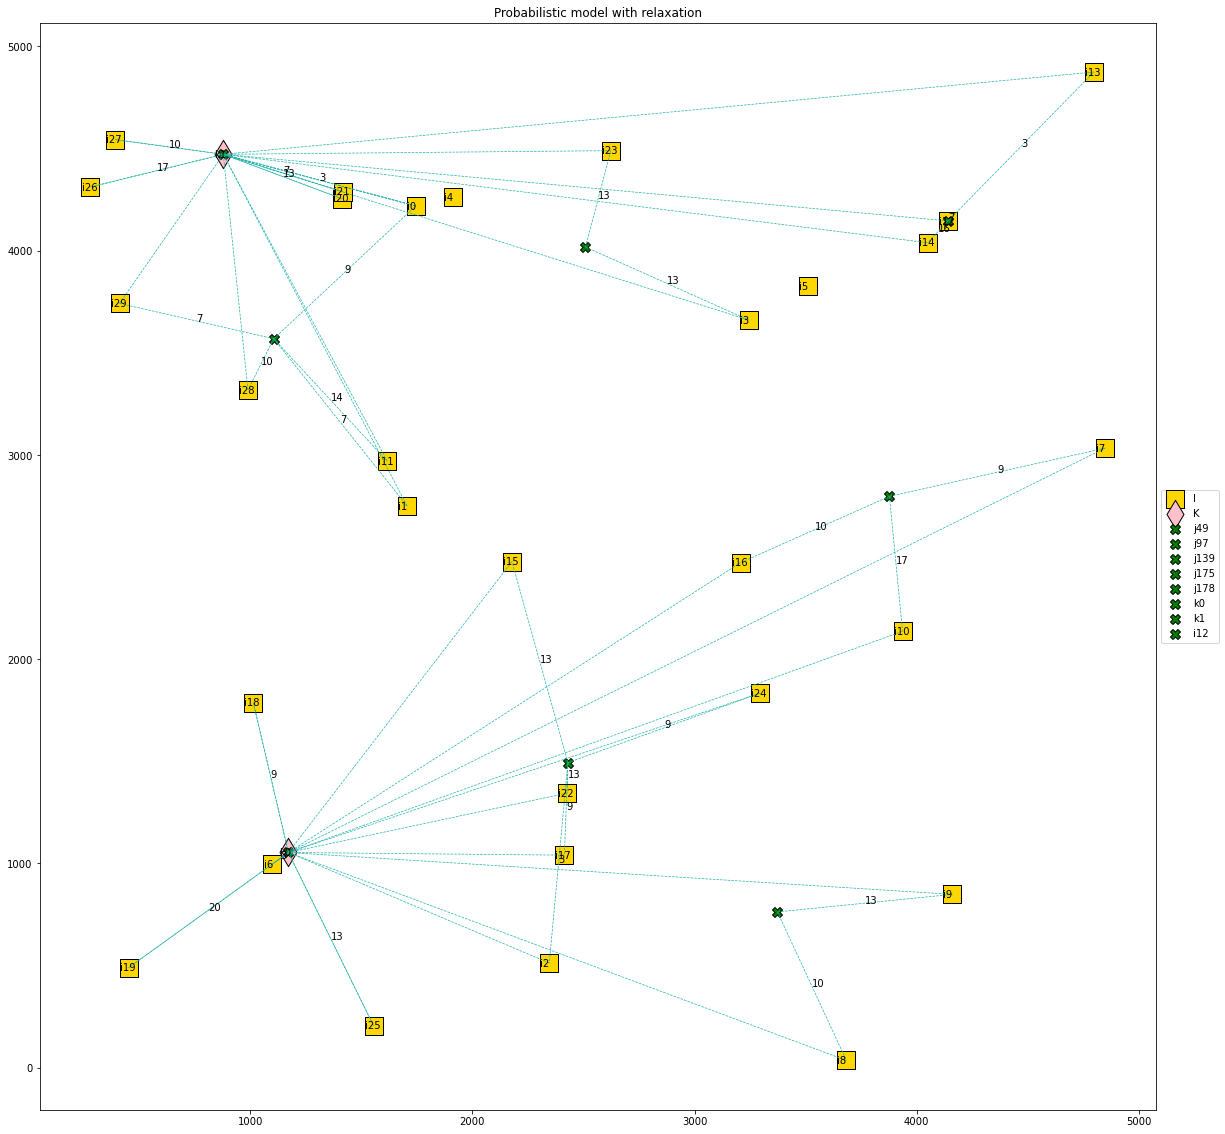

In [ ]:
SolutionGraph(I, K, J, model_prob_rel)

In [ ]:
#SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_prob_rel)

Deterministic model with relaxed constraints

In [ ]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [ ]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')

model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_det_rel.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [ ]:
model_det_rel.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)
model_det_rel.setParam('TimeLimit', hardlimit)
model_det_rel.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27860 rows, 14152 columns and 30914 nonzeros
Model fingerprint: 0x2a99975f
Variable types: 0 continuous, 14152 integer (232 binary)
Coefficient statistics:
  Matrix range     [9e-02, 9e+04]
  Objective range  [2e+04, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 1.096368e+07
Presolve removed 27602 rows and 13201 columns
Presolve time: 0.01s
Presolved: 258 rows, 951 columns, 1672 nonzeros
Found heuristic solution: objective 9763682.7511
Variable types: 0 continuous, 951 integer (284 binary)
Found heuristic solution: objective 9763682.7358

Root relaxation: objective 4.221300e+06, 708 iterations, 0.02 seconds (0.00 work units)

    Nod

In [ ]:
ListSolution(model_det_rel)

Number of solutions found: 10
0
4.96368e+06 
x_ikj[i0,k1,k1] 4
x_ikj[i1,k1,j139] 4
x_ikj[i2,k0,j175] 2
x_ikj[i3,k1,j97] 8
x_ikj[i6,k0,k0] 1
x_ikj[i7,k0,j178] 4
x_ikj[i8,k0,j49] 7
x_ikj[i9,k0,j49] 5
x_ikj[i10,k0,j178] 6
x_ikj[i11,k1,j139] 12
x_ikj[i12,k1,i12] 2
x_ikj[i13,k1,i12] 2
x_ikj[i14,k1,i12] 10
x_ikj[i15,k0,j175] 9
x_ikj[i16,k0,j178] 2
x_ikj[i17,k0,j175] 5
x_ikj[i18,k0,k0] 2
x_ikj[i19,k0,k0] 17
x_ikj[i20,k1,k1] 12
x_ikj[i21,k1,k1] 2
x_ikj[i22,k0,j175] 2
x_ikj[i23,k1,j97] 10
x_ikj[i24,k0,j175] 5
x_ikj[i25,k0,k0] 8
x_ikj[i26,k1,k1] 13
x_ikj[i27,k1,k1] 7
x_ikj[i28,k1,j139] 6
x_ikj[i29,k1,k1] 1
y_j[j49] 1
y_j[j97] 1
y_j[j139] 1
y_j[j175] 1
y_j[j178] 1
y_j[k0] 1
y_j[k1] 1
y_j[i12] 1


1
4.96368e+06 
x_ikj[i0,k1,k1] 4
x_ikj[i1,k1,j139] 4
x_ikj[i2,k0,j175] 2
x_ikj[i3,k1,j97] 8
x_ikj[i6,k0,k0] 1
x_ikj[i7,k0,j178] 4
x_ikj[i8,k0,j49] 7
x_ikj[i9,k0,j49] 5
x_ikj[i10,k0,j178] 6
x_ikj[i11,k1,j139] 12
x_ikj[i12,k1,i12] 2
x_ikj[i13,k1,i12] 2
x_ikj[i14,k1,i12] 10
x_ikj[i15,k0,j175] 9
x_ikj[i16,k0

In [ ]:
SolutionSummary(model_det_rel)

(      i  Number of drones
 0    i0                 4
 1    i1                 4
 2   i10                 6
 3   i11                12
 4   i12                 2
 5   i13                 2
 6   i14                10
 7   i15                 9
 8   i16                 2
 9   i17                 5
 10  i18                 2
 11  i19                17
 12   i2                 2
 13  i20                12
 14  i21                 2
 15  i22                 2
 16  i23                10
 17  i24                 5
 18  i25                 8
 19  i26                13
 20  i27                 7
 21  i28                 6
 22  i29                 1
 23   i3                 8
 24   i6                 1
 25   i7                 4
 26   i8                 7
 27   i9                 5,
       j  Number of drones
 0   i12                14
 1  j139                22
 2  j175                23
 3  j178                12
 4   j49                12
 5   j97                18
 6    k0                28


In [ ]:
#SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_prob_rel)

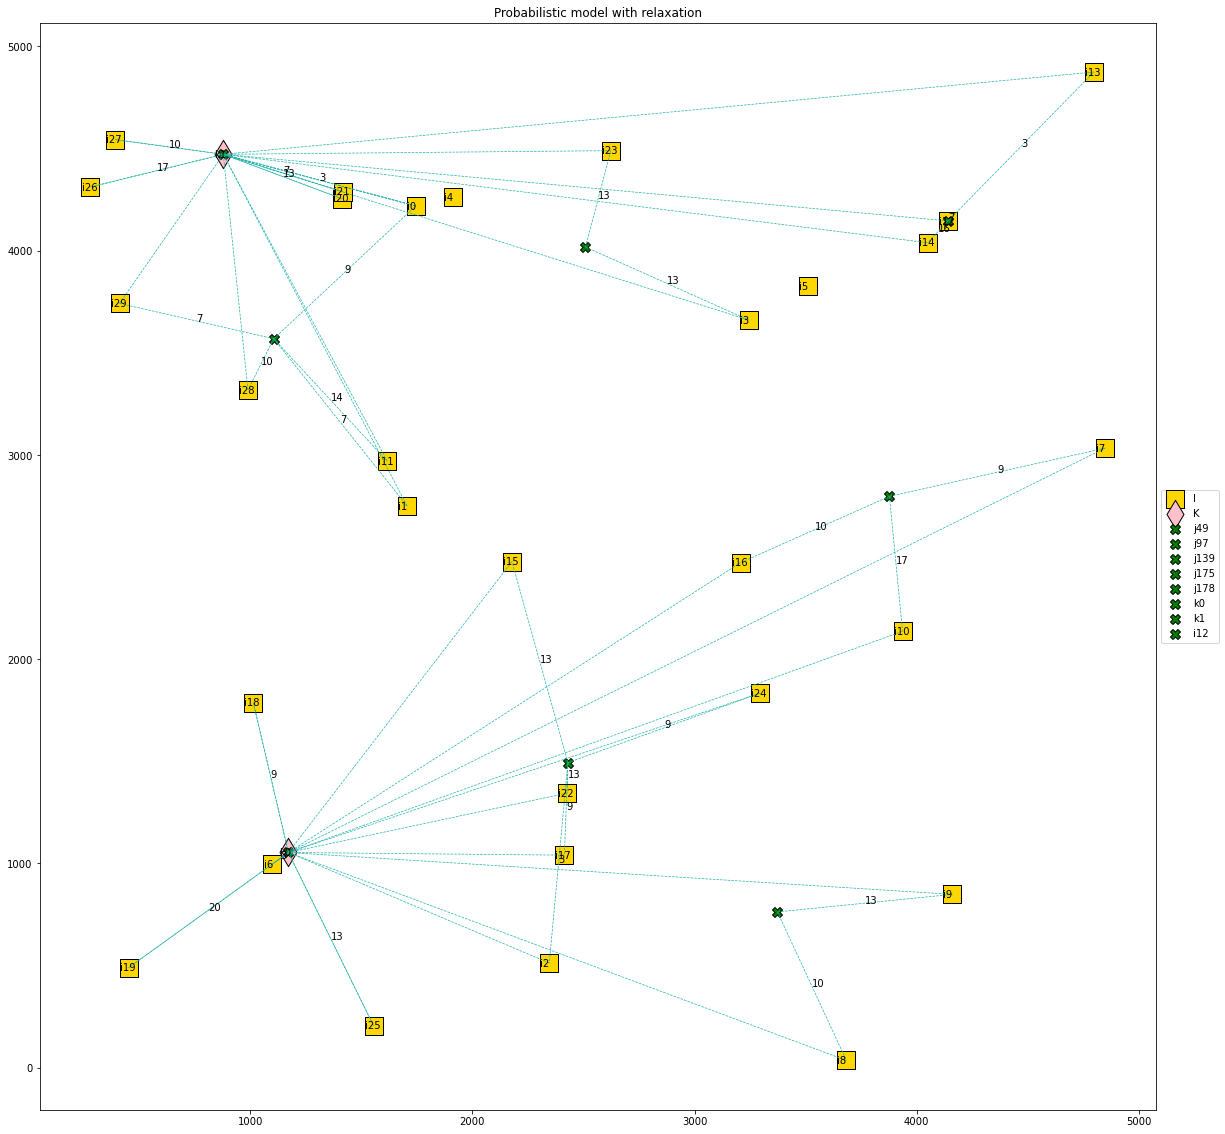

In [ ]:
SolutionGraph(I, K, J, model_prob_rel)

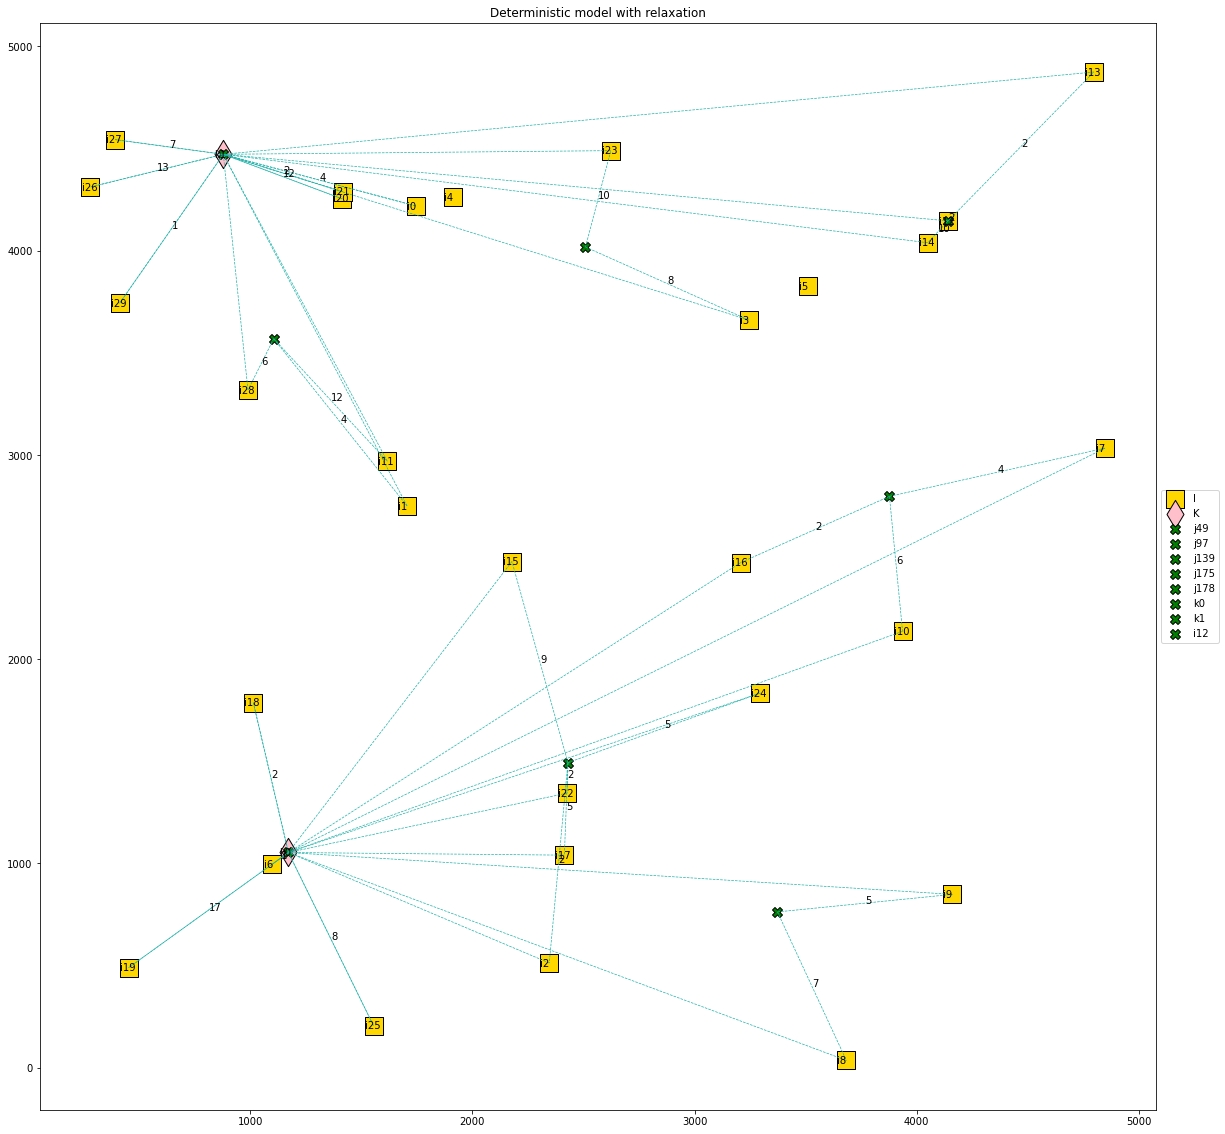

In [ ]:
SolutionGraph(I, K, J, model_det_rel)

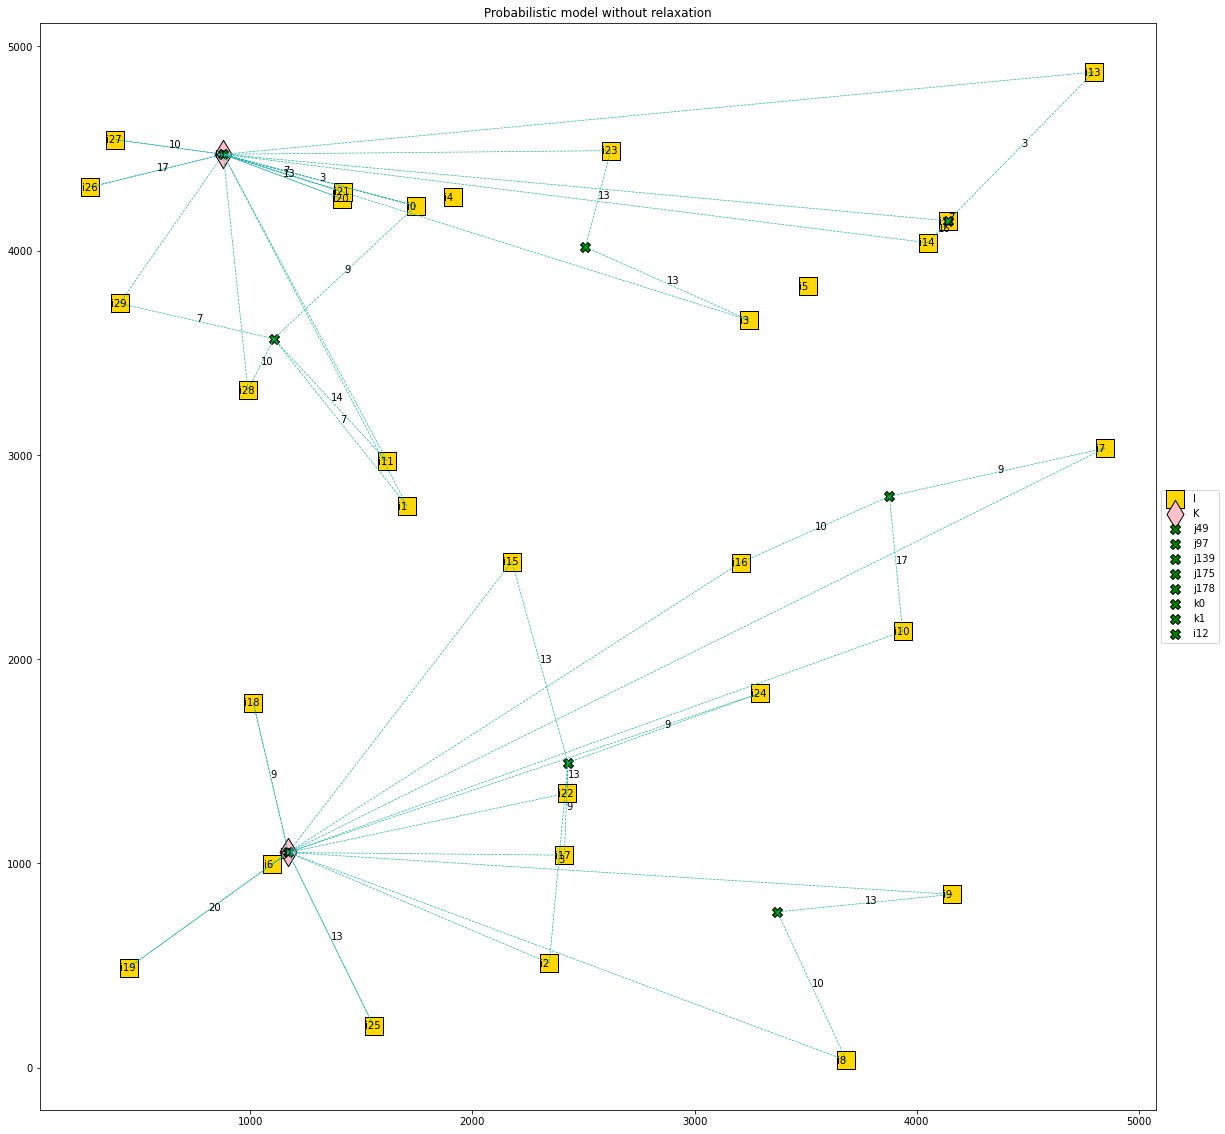

In [ ]:
SolutionGraph(I, K, J, model_prob)

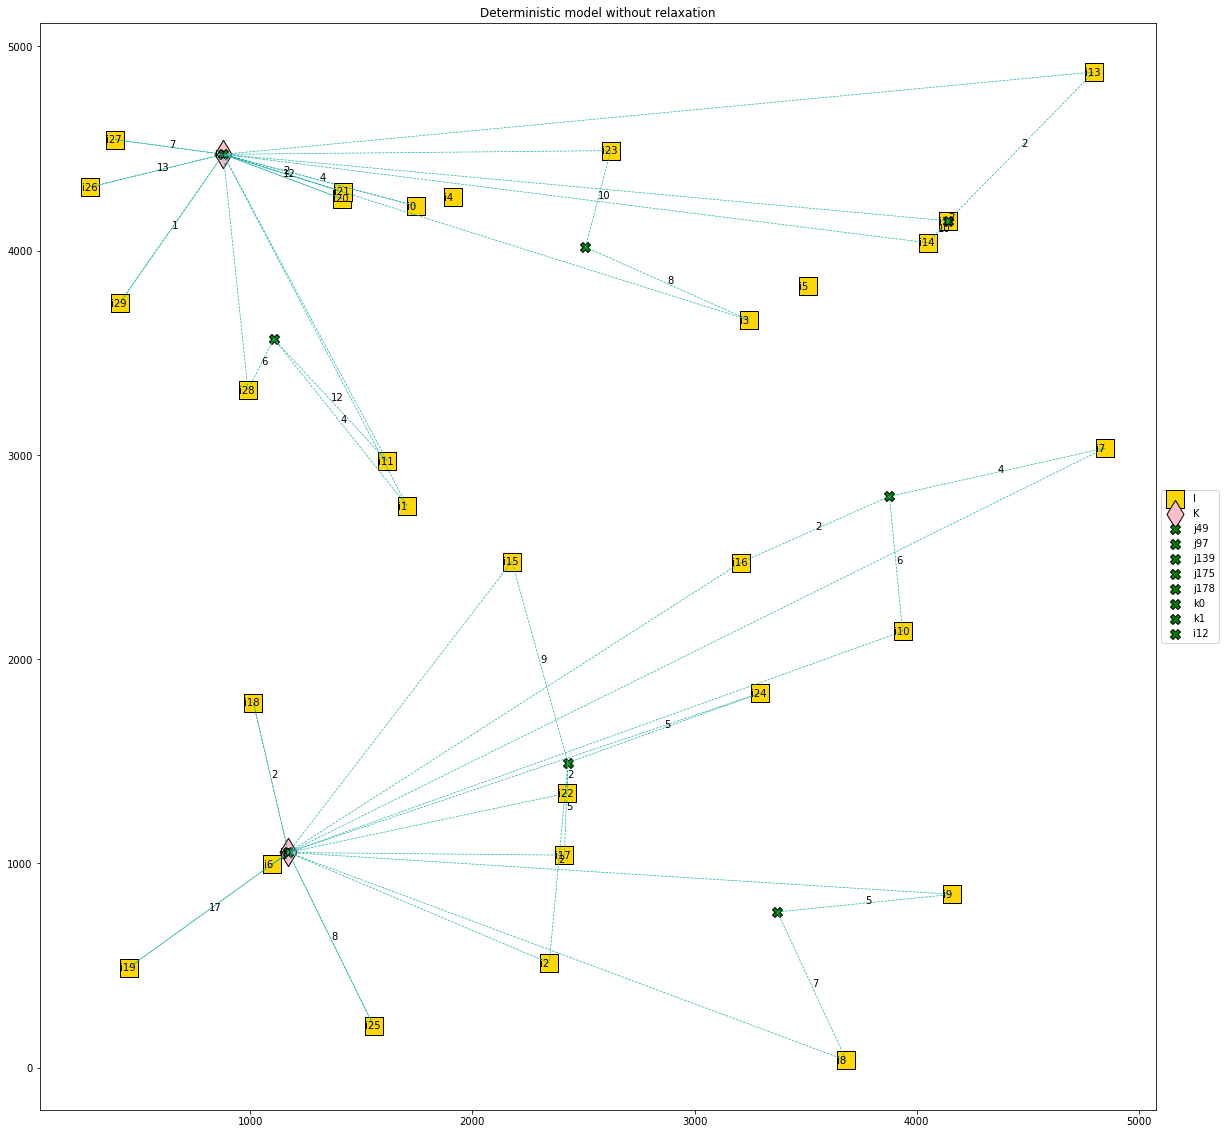

In [ ]:
SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty